##### In this notebook we will try to group the whole code into functions so that it is possible to visualize the frontal probabilities map for both the reanalysis data and the MUR data using Canny algorithm

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cv2
import xarray as xr
import os
from pathlib import Path
from scipy.ndimage import gaussian_filter
#plt.rcParams["figure.figsize"] = 10, 8
%matplotlib inline
import cmocean

### Importação dos dados

In [2]:
def get_data(data):
    
    """
    function to get our netCDF file that is stored in the data directory and convert it to a dataframe
    the data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #caso se esteja a importar os dados do MUR, renomear as colunas e passar a temperatura para Celsius
    if data.startswith('mur'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [3]:
df_reanalysis = get_data('IBI2014-2019.nc')   

In [4]:
df_mur_july = get_data('murJuly2019.nc')

In [5]:
df_mur_aug = get_data('murAugust2019.nc')

In [6]:
df_mur_sept = get_data('murSept2019.nc')

In [7]:
#Não faz sentido ter isto em função

def get_period(df):
    
    """
    Function that receives a dataframe that can have data relative to different days 
    and returns a dictionaire of dataframes (for each different day) (days) and an array with the different dates 
    its possible to find in our dataframe (specificday)
    """
    
    specificday = [pd.Timestamp(dd).strftime("%Y-%m-%d %H:%M:%S") for dd in df['time'].unique()]
    specificday = np.array(specificday, dtype=np.object)
  
    #create a dictionary to store the data frames for each day
    days = {elem : pd.DataFrame for elem in specificday}

    for key in days.keys():
        days[key] = df[:][df['time'] == key]
        
    return days, specificday

#after this function we only have to define the period we want to analyse

In [8]:
days_mur_set, specificday_mur_set = get_period(df_mur_sept)

In [9]:
days_r, specificday_r = get_period(df_reanalysis)

##### Define the period we want to analyse

Parece-me que a melhor maneira de fazer isto será definir o periodo diretamente à mão (como é feito na linha de baixo)

In [9]:
# period we want to analyse
ond2014_2019 = specificday_r[(specificday_r>='2014-10-01 12:00:00') & (specificday_r <= '2014-12-31 12:00:00') + (specificday_r>='2015-10-01 12:00:00') & (specificday_r <= '2015-12-31 12:00:00')+(specificday_r>='2016-10-01 12:00:00') & (specificday_r <= '2016-12-31 12:00:00')+(specificday_r>='2017-10-01 12:00:00') & (specificday_r <= '2017-12-31 12:00:00')+(specificday_r>='2018-10-01 12:00:00') & (specificday_r <= '2018-12-31 12:00:00')+(specificday_r>='2019-10-01 12:00:00') & (specificday_r <= '2019-12-31 12:00:00')]
ond2014_2019

array(['2014-10-01 12:00:00', '2014-10-02 12:00:00',
       '2014-10-03 12:00:00', '2014-10-04 12:00:00',
       '2014-10-05 12:00:00', '2014-10-06 12:00:00',
       '2014-10-07 12:00:00', '2014-10-08 12:00:00',
       '2014-10-09 12:00:00', '2014-10-10 12:00:00',
       '2014-10-11 12:00:00', '2014-10-12 12:00:00',
       '2014-10-13 12:00:00', '2014-10-14 12:00:00',
       '2014-10-15 12:00:00', '2014-10-16 12:00:00',
       '2014-10-17 12:00:00', '2014-10-18 12:00:00',
       '2014-10-19 12:00:00', '2014-10-20 12:00:00',
       '2014-10-21 12:00:00', '2014-10-22 12:00:00',
       '2014-10-23 12:00:00', '2014-10-24 12:00:00',
       '2014-10-25 12:00:00', '2014-10-26 12:00:00',
       '2014-10-27 12:00:00', '2014-10-28 12:00:00',
       '2014-10-29 12:00:00', '2014-10-30 12:00:00',
       '2014-10-31 12:00:00', '2014-11-01 12:00:00',
       '2014-11-02 12:00:00', '2014-11-03 12:00:00',
       '2014-11-04 12:00:00', '2014-11-05 12:00:00',
       '2014-11-06 12:00:00', '2014-11-07 12:0

In [11]:
set2019_mur = specificday_mur_set[(specificday_mur_set >='2019-09-01 09:00:00') & (specificday_mur_set<='2019-09-30 09:00:00')]

In [28]:
summer2019_r = specificday_r[(specificday_r >='2019-07-01 12:00:00') & (specificday_r<='2019-09-30 12:00:00')]

In [11]:
july10 = specificday_mur[(specificday_mur == '2019-07-10 09:00:00')]

In [12]:
july10_r = specificday_r[(specificday_r == '2019-07-10 12:00:00')]

In [52]:
july25 = specificday_mur[(specificday_mur == '2019-07-25 09:00:00')]

In [53]:
july25_r = specificday_r[(specificday_r == '2019-07-25 12:00:00')]

In [7]:
set10_2019 = specificday_r[(specificday_r =='2019-09-10 12:00:00')]
set10_2019

array(['2019-09-10 12:00:00'], dtype=object)

In [12]:
def canny_creation(days, Tmin, Tmax, sigma=0, apertureSize=3):  
    
    """
    Função que pega numa df com temperaturas relativas a um certo dia e retorna a matriz obtida após 
    aplicação do Canny com a mask para a zona continental
    """
    
    #Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
    Temp = days.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
    
    #Converter os valores de temperatura no formato uint8 com valores entre 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    #if its MUR data we have to apply gaussian filter with certain sigma value (~5)
    Temp_day = gaussian_filter(Temp_day, sigma=sigma)
    
    #apply the canny algorithm and plot the image with the edges
    canny = cv2.Canny(Temp_day, Tmin, Tmax, L2gradient=False, apertureSize=apertureSize)
    
    mask = np.isnan(np.flipud(Temp))    #Boolean array é True onde o array original (Temp) tinha valores Nan
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array cujos pixels= 255 quando mask=True
    #Fazer uma dilatação para assegurar que os pixeis que pertencem à costa não são considerados como frentes no canny
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    canny =np.ma.masked_where(mask_dilated==255, canny)
    
    return canny

In [13]:
def frontal_prob(period, days, Tmin, Tmax, MUR=False, sigma=0, apertureSize=3):
    """
    Função que retorna um array com a frontal probability de cada pixel
    """
    #if statment to define array shape based on which data it is
    if MUR==False:
        fp = np.zeros((121,169))
    elif MUR==True: 
        fp = np.zeros((1001,1401))
        
    for day in period:
        fp = fp + canny_creation(days[day], Tmin=Tmin, Tmax=Tmax, sigma=sigma, apertureSize=apertureSize)
    
    fp = fp/(len(period)*255)*100
    
    return fp

In [14]:
def visualization(period, days, Tmin, Tmax, MUR, sigma, apertureSize, vmin=None, vmax=None):
    
    """
    Função para visualizar o map of frontal probability e um histograma com as frontal probabilities
    """
    
    fp = frontal_prob(period=period, days=days, Tmin=Tmin, Tmax=Tmax, MUR=MUR, sigma=sigma, apertureSize=apertureSize)
    
    #fp=jas_data[Tmax]
    
    lat = np.array(days[period[0]]['latitude'].unique())
    lon = np.array(days[period[0]]['longitude'].unique())
    
    plt.rcParams["figure.figsize"] = (15, 25)
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    img = ax1.imshow(fp, cmocean.cm.thermal, vmin=vmin, vmax=vmax, extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.colorbar(img, orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
    #plt.title("Map of frontal probability", fontsize=20)

    ax2 = fig.add_subplot(2,1,2)
    ax2.hist(fp.flatten(), bins=100);
    plt.xlabel('Frontal Probability',fontsize=10)
    


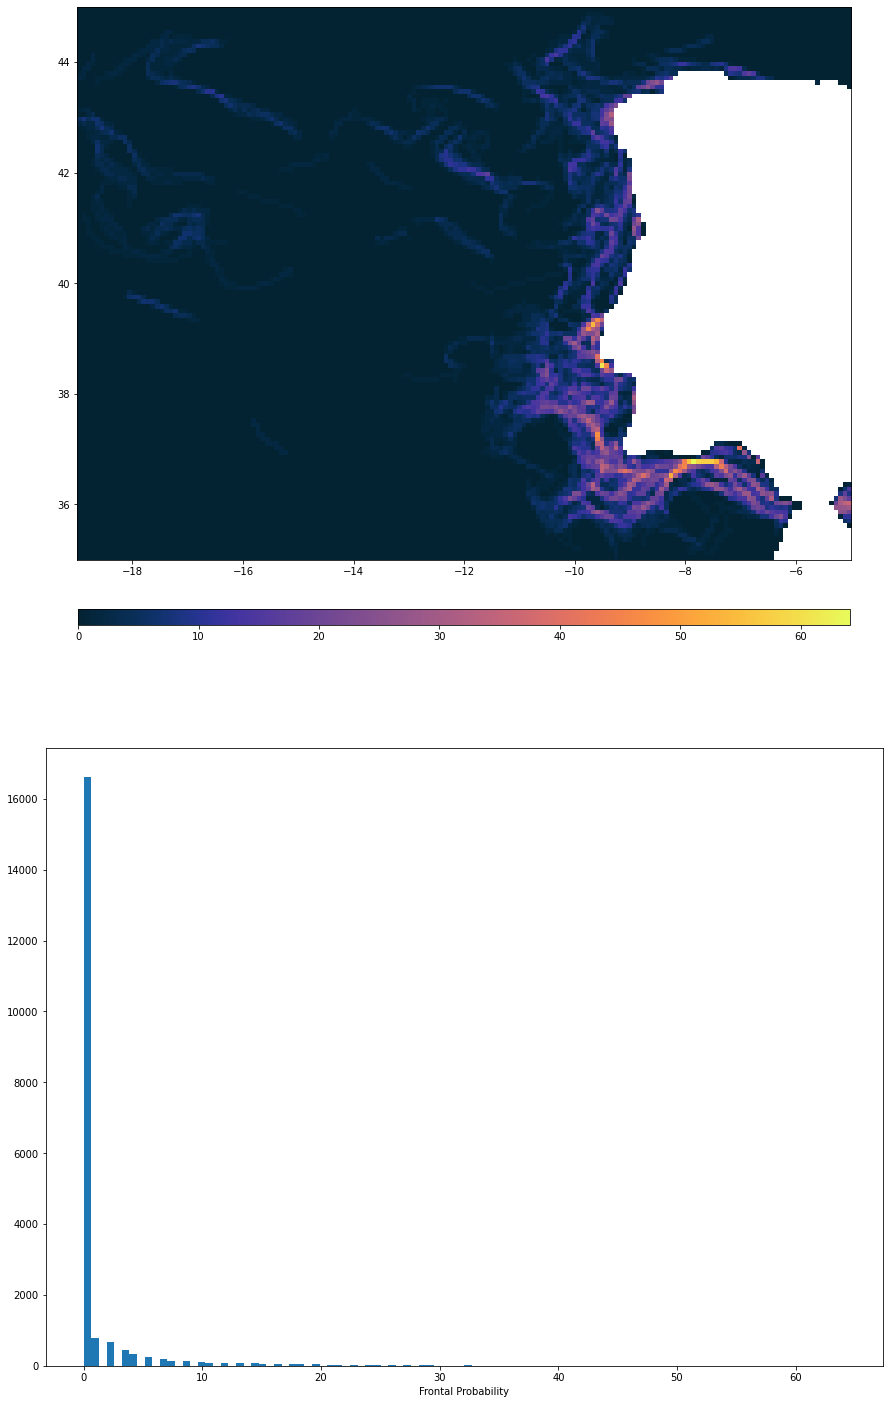

In [36]:
visualization(period = summer2019_r, days=days_r, Tmin=90, Tmax=180, MUR=False, sigma=0, apertureSize=3, vmax=None)

#### Para agregar os varios netCDFs dos dados do MUR e aplicar-lhe o algoritmo

In [18]:
days_mur_sept, specificday_mur_sept = get_period(df_mur_sept)

In [19]:
days_mur_aug, specificday_mur_aug = get_period(df_mur_aug)

In [20]:
days_mur_july, specificday_mur_july = get_period(df_mur_july)

In [21]:
def Merge(dict1, dict2):
    """
    Function to merge 2 dictionaires
    """
    
    res = {**dict1, **dict2}
    return res

In [22]:
days_mur_augSet = Merge(days_mur_aug, days_mur_sept)

In [23]:
days_mur_summer = Merge(days_mur_july, days_mur_augSet)

In [24]:
days_mur_summer

{'2019-07-01 09:00:00':           latitude  longitude                time     thetao
 0             35.0 -19.000000 2019-07-01 09:00:00  21.459015
 31            35.0 -18.990000 2019-07-01 09:00:00  21.488007
 62            35.0 -18.980000 2019-07-01 09:00:00  21.506012
 93            35.0 -18.969999 2019-07-01 09:00:00  21.509003
 124           35.0 -18.959999 2019-07-01 09:00:00  21.502991
 ...            ...        ...                 ...        ...
 43474276      45.0  -5.040000 2019-07-01 09:00:00  17.605988
 43474307      45.0  -5.030000 2019-07-01 09:00:00  17.605988
 43474338      45.0  -5.020000 2019-07-01 09:00:00  17.602997
 43474369      45.0  -5.010000 2019-07-01 09:00:00  17.596985
 43474400      45.0  -5.000000 2019-07-01 09:00:00  17.588989
 
 [1402401 rows x 4 columns],
 '2019-07-02 09:00:00':           latitude  longitude                time     thetao
 1             35.0 -19.000000 2019-07-02 09:00:00  21.085999
 32            35.0 -18.990000 2019-07-02 09:00:00  21.

In [25]:
specificday_mur_summer = np.concatenate([specificday_mur_july, specificday_mur_aug, specificday_mur_sept])

In [26]:
specificday_mur_summer

array(['2019-07-01 09:00:00', '2019-07-02 09:00:00',
       '2019-07-03 09:00:00', '2019-07-04 09:00:00',
       '2019-07-05 09:00:00', '2019-07-06 09:00:00',
       '2019-07-07 09:00:00', '2019-07-08 09:00:00',
       '2019-07-09 09:00:00', '2019-07-10 09:00:00',
       '2019-07-11 09:00:00', '2019-07-12 09:00:00',
       '2019-07-13 09:00:00', '2019-07-14 09:00:00',
       '2019-07-15 09:00:00', '2019-07-16 09:00:00',
       '2019-07-17 09:00:00', '2019-07-18 09:00:00',
       '2019-07-19 09:00:00', '2019-07-20 09:00:00',
       '2019-07-21 09:00:00', '2019-07-22 09:00:00',
       '2019-07-23 09:00:00', '2019-07-24 09:00:00',
       '2019-07-25 09:00:00', '2019-07-26 09:00:00',
       '2019-07-27 09:00:00', '2019-07-28 09:00:00',
       '2019-07-29 09:00:00', '2019-07-30 09:00:00',
       '2019-07-31 09:00:00', '2019-08-01 09:00:00',
       '2019-08-02 09:00:00', '2019-08-03 09:00:00',
       '2019-08-04 09:00:00', '2019-08-05 09:00:00',
       '2019-08-06 09:00:00', '2019-08-07 09:0

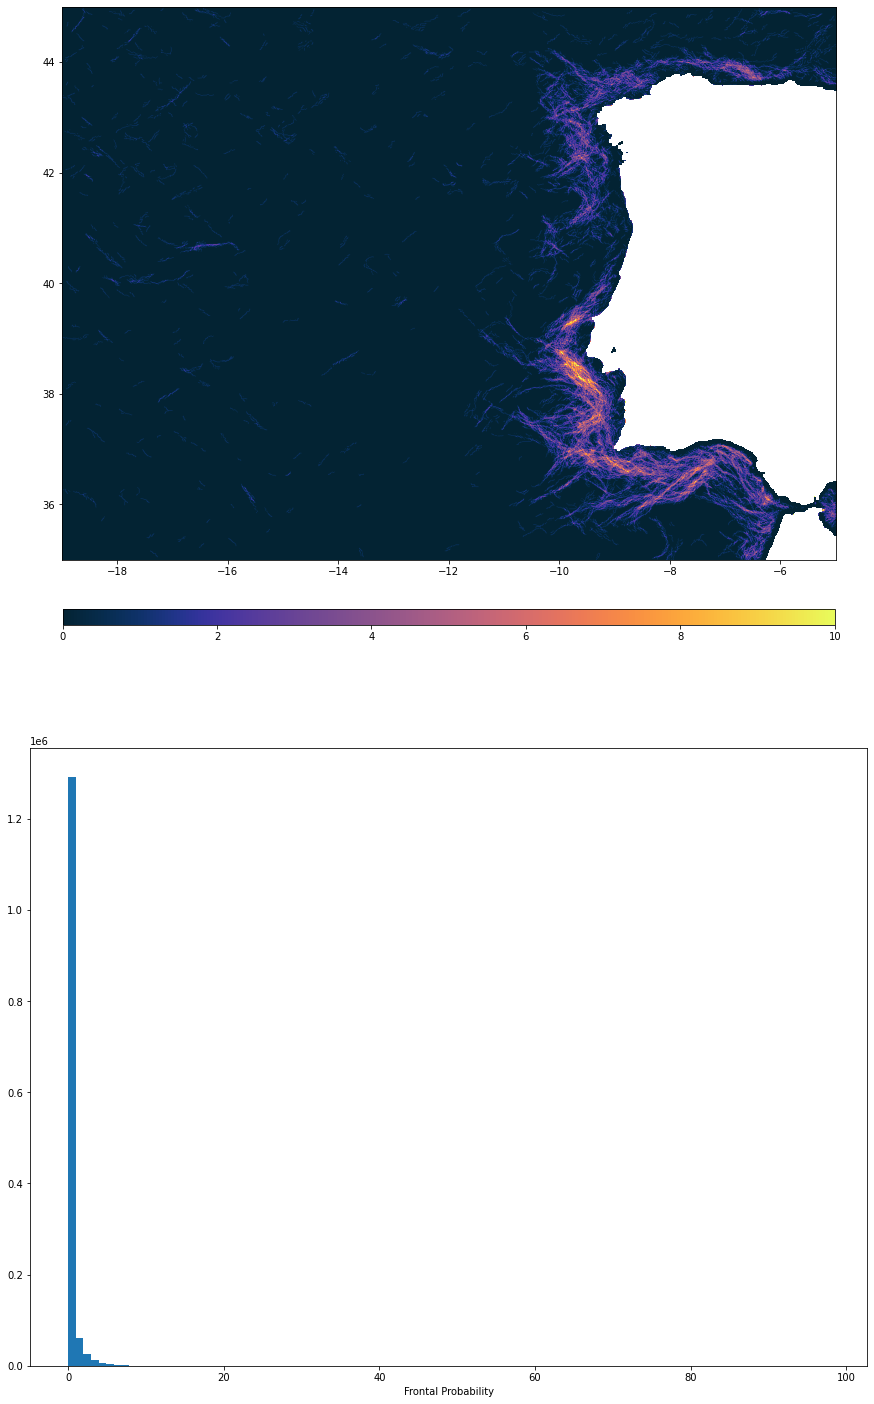

In [27]:
visualization(period = specificday_mur_summer, days=days_mur_summer, Tmin=300, Tmax=350, MUR=True, sigma=5, apertureSize=5, vmax=10)